In [1]:
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# use ggplot styles for graphs
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [3]:
# import probabilistic models
from bayes_vi.model import Model

# import utils
from bayes_vi.utils import to_ordered_dict
from bayes_vi.utils.datasets import make_dataset_from_df
from bayes_vi.utils.symplectic_integrators import LeapfrogIntegrator

In [4]:
# mcmc imports
from bayes_vi.inference.mcmc import MCMC
from bayes_vi.inference.mcmc.transition_kernels import HamiltonianMonteCarlo, NoUTurnSampler, RandomWalkMetropolis
from bayes_vi.inference.mcmc.stepsize_adaptation_kernels import SimpleStepSizeAdaptation, DualAveragingStepSizeAdaptation

In [5]:
# vi imports 
from bayes_vi.inference.vi import VI
from bayes_vi.inference.vi.surrogate_posteriors import ADVI, NormalizingFlow
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn

## 1. Example Workflow

A Bayesian modeling worklow using this package could look like this.

### 1.1. Create a Dataset
Create a `tf.data.Dataset` from your data. For this example consider some case some univariate Gaussian fake data.

In [6]:
num_datapoints = 20
loc = 7
scale = 3
true_dist = tfd.Normal(loc=loc, scale=scale)
y = true_dist.sample(num_datapoints)

The package provides a utility function `make_dataset_from_df` for easy construction of a dataset from a `pd.DataFrame`.

In [7]:
data = pd.DataFrame(dict(y=y))
dataset = make_dataset_from_df(data, target_names=['y'], format_features_as='dict')

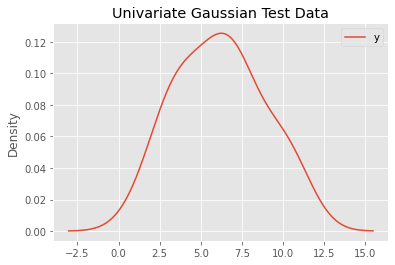

In [8]:
ax = data.plot(kind='kde', title='Univariate Gaussian Test Data')

### 1.2. Define a Bayesian Model

To define a Bayesian `Model`, simply provide an `collections.OrderedDict` of prior distributions as `tfp.distribution.Distirbution`s and a likelihood function, which takes the parameters as inputs by name.

In [9]:
priors = collections.OrderedDict(
    loc = tfd.Normal(loc=0., scale=10.),
    scale = tfd.HalfNormal(scale=10.)
)

def likelihood(loc, scale): 
    return tfd.Normal(loc=loc, scale=scale)

In [10]:
model = Model(priors=priors, likelihood=likelihood)

It is possible to provide a list of constraining bijectors on construction of the model, which allows for computations on an unconstrained space.

If no such list is defined, default bijectors for each prior are chosen.

### 1.3. Run Inference Algorithm of Choice

With this simple setup, you can now use either MCMC or variational inference to do Bayesian inference.

#### 1.3.1. Run MCMC (e.g. with No-U-Turn Sampler with dual averaging stepsize adaptation)

Note that the transition kernel may have various additional parameters. Here we use just the defaults and only provide the stepsize adaptation kernel.

In [11]:
NUM_CHAINS = 2
NUM_SAMPLES = 4000
NUM_BURNIN_STEPS = 1000

stepsize_adaptation_kernel = DualAveragingStepSizeAdaptation(num_adaptation_steps=int(NUM_BURNIN_STEPS*0.8))

kernel = NoUTurnSampler(stepsize_adaptation_kernel=stepsize_adaptation_kernel)

mcmc = MCMC(model=model, dataset=dataset, transition_kernel=kernel)

mcmc_result = mcmc.fit(
    num_chains=NUM_CHAINS, 
    num_samples=NUM_SAMPLES, 
    num_burnin_steps=NUM_BURNIN_STEPS,
    progress_bar=True,
)

The `mcmc_result` is a wrapper containing the sample results `mcmc_result.samples` and additional traced metrics specific to the kernel `mcmc_result.trace`.

To visualize the results, one can use existing libraries like arviz (https://arviz-devs.github.io/arviz/index.html).

Later versions of this package should allow for a seamless integration with arviz, but for now we have to reformat the sample results to conform to arviz conventions.

In [12]:
# adapt sample results to arviz required format --- later versions should allow for seamless integration with arviz
posterior_samples = to_ordered_dict(model.param_names, tf.nest.map_structure(lambda v: v.numpy().T, mcmc_result.samples))

In [13]:
az.summary(posterior_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
loc,6.135,0.646,4.890,7.310,0.009,0.007,4897.0,4897.0,4967.0,4232.0,1.0
scale,2.833,0.514,1.989,3.828,0.008,0.006,4597.0,4217.0,5307.0,3819.0,1.0


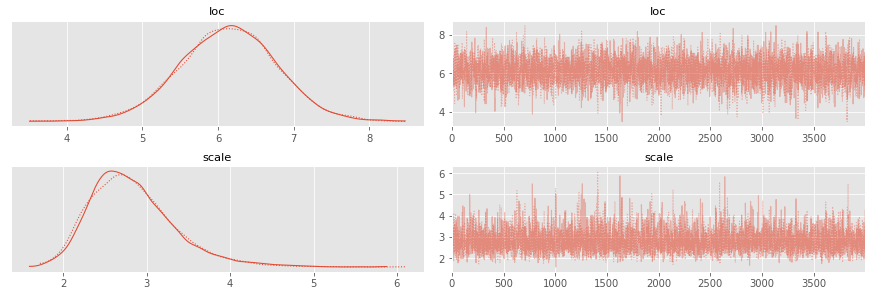

In [14]:
ax = az.plot_trace(posterior_samples)

#### 1.3.2. Run Variational Inference (e.g. meanfield ADVI)


Instead of MCMC methods, we might want to use variational inference.

Choose a surrogate posterior, e.g. meanfield `ADVI`, a discrepancy function from `tfp.vi`, e.g. `tfp.vi.kl_reverse` , and select some optimization parameters (number of optimzation steps, sample size to approximate variational loss, optimizer, learning rate).

In [15]:
NUM_STEPS = 1000
SAMPLE_SIZE = 10
LEARNING_RATE = 1e-2

surrogate_posterior = ADVI(model=model, mean_field=True)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, meanfield_advi_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)


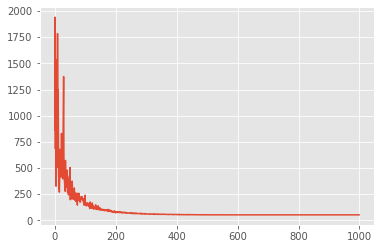

In [16]:
ax = plt.plot(meanfield_advi_losses)

In [17]:
df = pd.DataFrame(approx_posterior.sample(5000))

df.describe(percentiles=[0.03, 0.5, 0.97]).T

,count,mean,std,min,3%,50%,97%,max
loc,5000.0,6.104273,0.621283,3.760990,4.924492,6.115833,7.258379,8.165336
scale,5000.0,2.807804,0.435924,1.296883,1.978388,2.813874,3.635254,4.231164


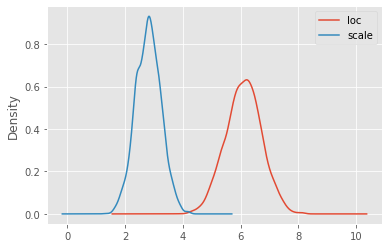

In [18]:
ax = df.plot(kind='kde')

## 2. Normalizing Flows for Variational Inference

Continuing the simple example above, this is how you can flexibly define surrogate posteriors based on Normalizing flows for variational Bayesian inference.

By default, the base distribution is a standard diagonal Gaussian.

This example uses the predefined trainable `AffineFlow` bijector, but any parameterized `tfp.bijectors.Bijector` can be used. Just define your own!
You can construct more expressive flows by making use of the `tfp.bijectors.Chain` bijector to define compositions of flows.

In [19]:
ndims = model.flat_unconstrained_param_event_ndims # this is the number of dimensions of the unconstrained parameter space

### 2.1. Affine Flows

In [20]:
flow_bijector = AffineFlow(ndims)

surrogate_posterior = NormalizingFlow(model=model, flow_bijector=flow_bijector)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, affine_flow_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)

To define continuous normalizing flows, you may use is the `tfp.bijectors.FFJORD` bijector.

### 2.2. Continuous Flows

In [21]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(64, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)

flow_bijector = get_continuous_flow_bijector(ndims)

surrogate_posterior = NormalizingFlow(model=model, flow_bijector=flow_bijector)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, cnf_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)

### 2.3. Comparison

Have a look at the optimzation behaviors in comparison.

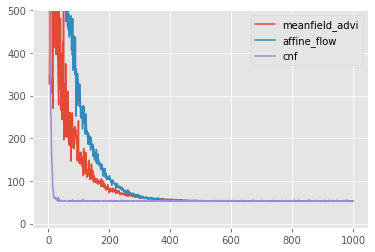

In [22]:
ax = pd.DataFrame({'meanfield_advi': meanfield_advi_losses, 'affine_flow': affine_flow_losses, 'cnf': cnf_losses}).plot(ylim=(-10,500))

## 3. Augmented Normalizing Flows for Variational Inference

The package allows to easily define augmented normalizing flows. This obviously has no advantages, at least for such a simple example model.

Simple choose a number of extra dimensions `extra_ndims` and define the flow bijector on the augmented space, i.e. on dimensions `ndims + extra_ndims`.

The optimization problem is solved on the augmented space by lifting the target distribution with the conditional `posterior_lift_distribution`, which by default is simply `lambda _: tfd.MultivariateNormalDiag(loc=tf.zeros(extra_ndims), scale_diag=tf.ones(extra_ndims))`.

In [23]:
ndims = model.flat_unconstrained_param_event_ndims # this is the number of dimensions of the unconstrained parameter space

extra_ndims = 2 # dimensions of the augmentation space 

In [24]:
flow_bijector = AffineFlow(ndims + extra_ndims)

surrogate_posterior = NormalizingFlow(model=model, flow_bijector=flow_bijector, extra_ndims=extra_ndims)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, affine_flow_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)

In [25]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(64, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)

flow_bijector = get_continuous_flow_bijector(ndims + extra_ndims)

surrogate_posterior = NormalizingFlow(model=model, flow_bijector=flow_bijector, extra_ndims=extra_ndims)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, cnf_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)

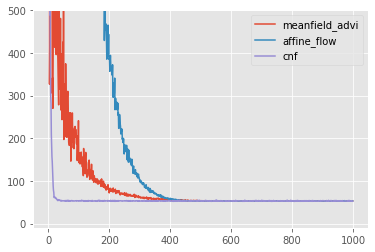

In [26]:
ax = pd.DataFrame({'meanfield_advi': meanfield_advi_losses, 'affine_flow': affine_flow_losses, 'cnf': cnf_losses}).plot(ylim=(-10,500))

## 4. Hamiltonian Normalizing Flows

As another example consider Hamiltonian Normalizing Flows (HNF) as motivated by Toth, P., Rezende, D. J., Jaegle, A., Racanière, S., Botev, A., & Higgins, I. (2019). Hamiltonian Generative Networks. ArXiv. http://arxiv.org/abs/1909.13789 .

HNFs are based on defining augmented flows as the Hamiltonian dynamics of a family of Hamiltonian systems. 

To compute such dynamics, we use the symplectic leapfrog integrator. 

The package provides an implementation of a general Hamiltonian Flow bijector.

### 4.1. Verify Hamiltonian Flow Bijector
To test the implementation the Hamiltonian Flow Bijector, consider the Hamiltonian of a 1d harmonic oscillator with mass $m=1$ and constant $k=1$:

$H(q,p) = T(p) + U(q) = 0.5 p^2 + 0.5 q^2$.

We know that this should yield an oscillating dynamic, which manifests as a circle on phase space.

In [27]:
T = lambda p: 0.5*p**2
U = lambda q: 0.5*q**2

# event dims can be ignore in this example, because they are only used to construct trainable default energy function if none are provided explicitly
hamiltonian_flow = HamiltonianFlow(
    event_dims=1, 
    potential_energy_fn=U, 
    kinetic_energy_fn=T, 
    symplectic_integrator=LeapfrogIntegrator(), 
    step_sizes=0.5, 
    num_integration_steps=1
) 

initial_state = tf.constant([1.0, 0.0])
path = [initial_state.numpy()]

for _ in range(20):
    path.append(hamiltonian_flow.forward(path[-1]).numpy())
path = np.stack(path)

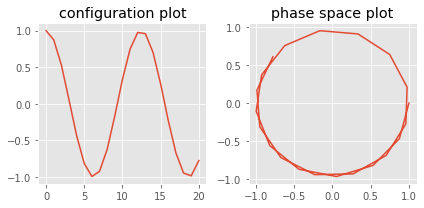

In [28]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(6,3))

ax1.plot(path[:, 0])
ax1.set_title('configuration plot')

ax2.plot(path[:,0], path[:,1])
ax2.set_title('phase space plot')
plt.tight_layout()

### 4.2. Hamiltonian Normalizing Flows

In the case of HNFs the augmentation space has the same dimension as the parameter space.

In [29]:
ndims = model.flat_unconstrained_param_event_ndims # this is the number of dimensions of the unconstrained parameter space

extra_ndims = ndims # dimensions of the augmentation space 

For simplicity, we use the default MLP based potential and kinetic energy functions.

In [30]:
flow_bijector = HamiltonianFlow(ndims, step_sizes=tf.Variable(0.1), num_integration_steps=2)

surrogate_posterior = NormalizingFlow(model=model, flow_bijector=flow_bijector, extra_ndims=extra_ndims)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, hnf_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)

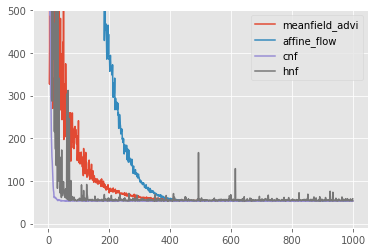

In [31]:
ax = pd.DataFrame({'meanfield_advi': meanfield_advi_losses, 'affine_flow': affine_flow_losses, 'cnf': cnf_losses, 'hnf': hnf_losses}).plot(ylim=(-10,500))

An interesting observation is that HNFs become more stable and perform better, if the base distribution is trainable.

This compensates for the problem, that volume preserving flows like HNFs can only permute the densities of the base distribution. 

In [32]:
flow_bijector = HamiltonianFlow(ndims, step_sizes=tf.Variable(0.1), num_integration_steps=2)

base_distribution = tfd.MultivariateNormalDiag(loc=tf.Variable([0.0]*2*ndims), scale_diag=tf.Variable([0.1]*2*ndims))

surrogate_posterior = NormalizingFlow(model=model, flow_bijector=flow_bijector, base_distribution=base_distribution, extra_ndims=extra_ndims)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, hnf_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)

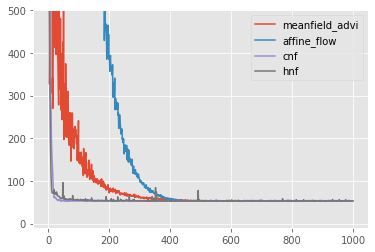

In [33]:
ax = pd.DataFrame({'meanfield_advi': meanfield_advi_losses, 'affine_flow': affine_flow_losses, 'cnf': cnf_losses, 'hnf': hnf_losses}).plot(ylim=(-10,500))

## 5. Regression Model Example

As a final example, this is how to define regression models.

### 5.1. Create a Dataset
Again, create a `tf.data.Dataset` from your data or, in this case, generate some fake dataset.

In [34]:
num_datapoints = 50
beta0 = 7
beta1 = 3
scale = 10
x = tf.random.normal((num_datapoints,), mean=0.0, stddev=10.0)
true_dist = tfd.Normal(loc=beta0 + x*beta1, scale=scale)
y = true_dist.sample()

The package provides a utility function `make_dataset_from_df` for easy construction of a dataset from a `pd.DataFrame`.

In [35]:
data = pd.DataFrame(dict(x=x, y=y))
dataset = make_dataset_from_df(data, target_names=['y'], feature_names=['x'], format_features_as='dict')

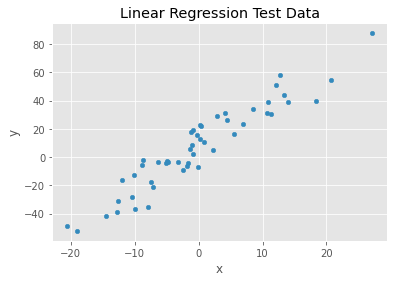

In [36]:
ax = data.plot(x='x', y='y', kind='scatter', title='Linear Regression Test Data')

### 1.2. Define a Bayesian Model

To define a Bayesian `Model`, simply provide an `collections.OrderedDict` of prior distributions as `tfp.distribution.Distirbution`s and a likelihood function, which takes the parameters and the features as inputs.

In [37]:
# define priors
priors = collections.OrderedDict(
    beta_0 = tfd.Normal(loc=0., scale=10.),
    beta_1 = tfd.Normal(loc=0., scale=10.),
    scale = tfd.HalfNormal(scale=10.),
)

# define likelihood
def likelihood(beta_0, beta_1, scale, features):
    linear_response = beta_0 + beta_1*features['x']
    return tfd.Normal(loc=linear_response, scale=scale)

In [38]:
model = Model(priors=priors, likelihood=likelihood)

### 1.3. Run Inference Algorithm of Choice

You can now again use either MCMC or variational inference to do Bayesian inference.

#### 1.3.1. Run MCMC (e.g. with Random Walk Metropolis)

In [39]:
NUM_CHAINS = 2
NUM_SAMPLES = 4000
NUM_BURNIN_STEPS = 1000


kernel = RandomWalkMetropolis()

mcmc = MCMC(model=model, dataset=dataset, transition_kernel=kernel)

mcmc_result = mcmc.fit(
    num_chains=NUM_CHAINS, 
    num_samples=NUM_SAMPLES, 
    num_burnin_steps=NUM_BURNIN_STEPS,
    progress_bar=True,
)

The `mcmc_result` is a wrapper containing the sample results `mcmc_result.samples` and additional traced metrics specific to the kernel `mcmc_result.trace`.

To visualize the results, one can use existing libraries like arviz (https://arviz-devs.github.io/arviz/index.html).

Later versions of this package should allow for a seamless integration with arviz, but for now we have to reformat the sample results to conform to arviz conventions.

In [40]:
# adapt sample results to arviz required format --- later versions should allow for seamless integration with arviz
posterior_samples = to_ordered_dict(model.param_names, tf.nest.map_structure(lambda v: v.numpy().T, mcmc_result.samples))

In [41]:
az.summary(posterior_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0,7.406,1.303,4.549,9.655,0.127,0.090,105.0,105.0,106.0,160.0,1.02
beta_1,2.808,0.139,2.559,3.075,0.006,0.004,623.0,614.0,611.0,588.0,1.01
scale,9.705,0.851,8.384,11.415,0.052,0.037,270.0,270.0,268.0,333.0,1.01


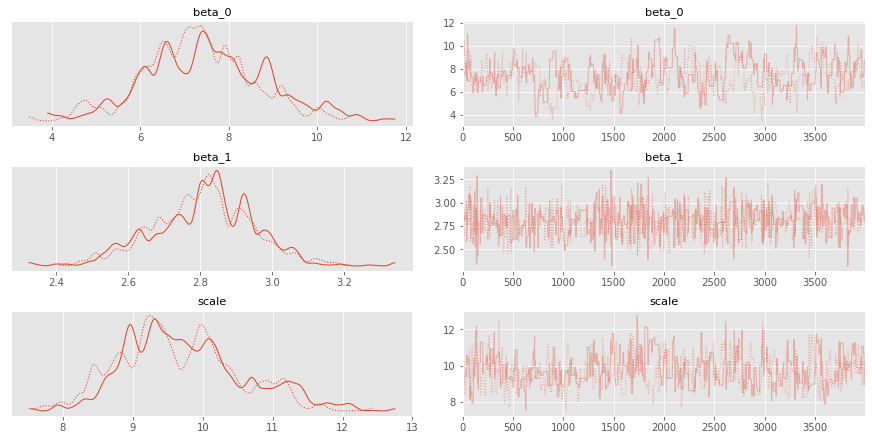

In [42]:
ax = az.plot_trace(posterior_samples)

#### 1.3.2. Run Variational Inference (e.g. full rank ADVI)


In [47]:
NUM_STEPS = 1000
SAMPLE_SIZE = 10
LEARNING_RATE = 1e-2

surrogate_posterior = ADVI(model=model)

vi = VI(model=model, dataset=dataset, surrogate_posterior=surrogate_posterior, discrepancy_fn=tfp.vi.kl_reverse)

approx_posterior, meanfield_advi_losses = vi.fit(
    optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), 
    num_steps=NUM_STEPS, 
    sample_size=SAMPLE_SIZE, 
    progress_bar=True
)


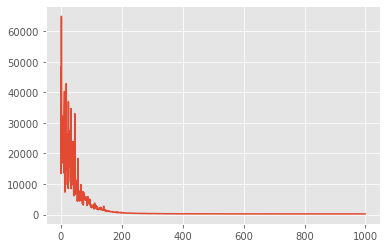

In [48]:
ax = plt.plot(meanfield_advi_losses)

In [49]:
df = pd.DataFrame(approx_posterior.sample(5000))

df.describe(percentiles=[0.03, 0.5, 0.97]).T

,count,mean,std,min,3%,50%,97%,max
beta_0,5000.0,7.245375,1.274100,2.583512,4.786098,7.276291,9.609860,11.522717
beta_1,5000.0,2.821689,0.139731,2.278940,2.550975,2.822689,3.082309,3.285474
scale,5000.0,9.557847,0.901075,6.517124,7.838509,9.554193,11.267960,13.032275


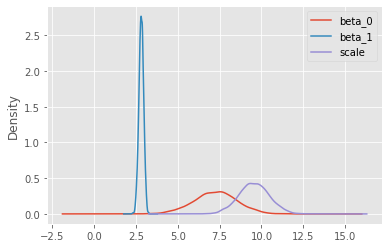

In [50]:
ax = df.plot(kind='kde')